In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from PIL import Image
from glob import glob
import cv2
import gc
import os

In [3]:

from sklearn.model_selection import train_test_split
from sklearn import metrics


In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [5]:
path =r"C:\Users\rahul\Downloads\archive"
classes = os.listdir(path)
classes

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

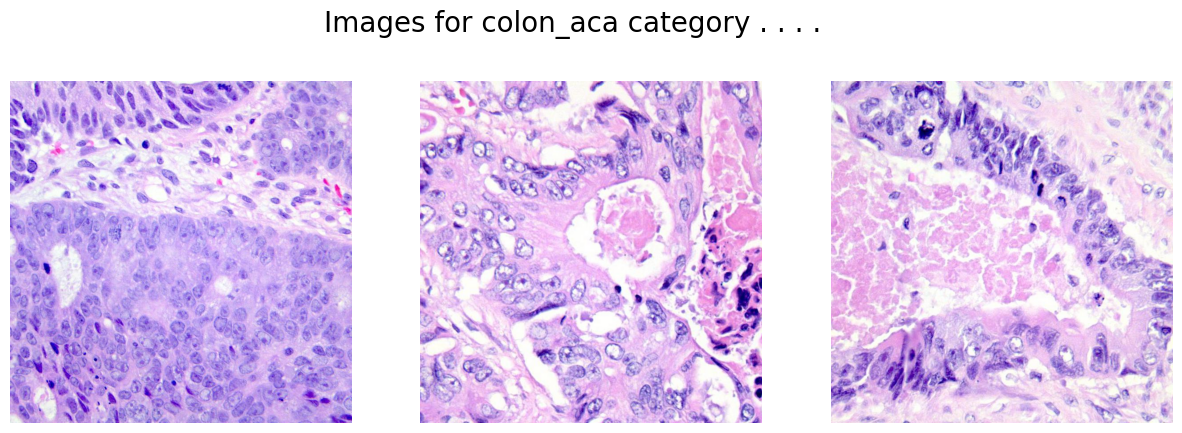

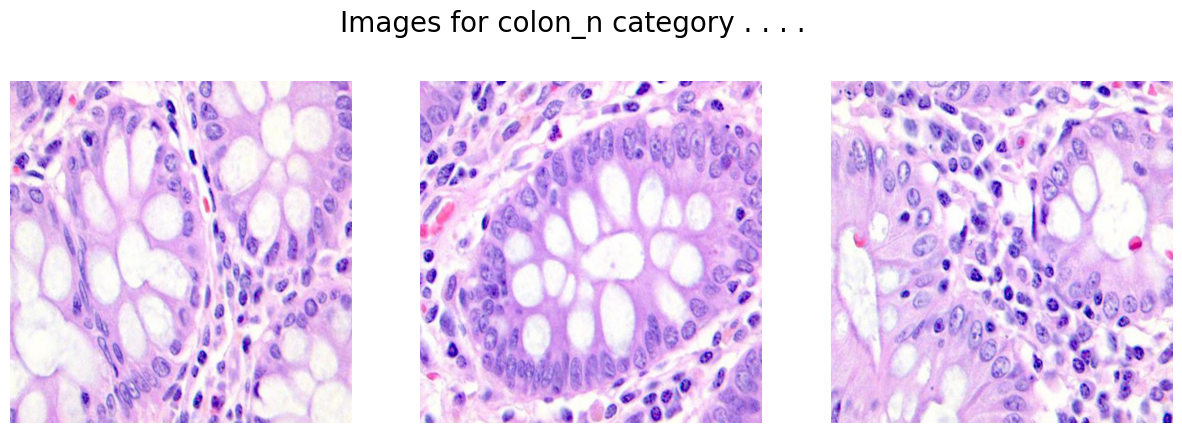

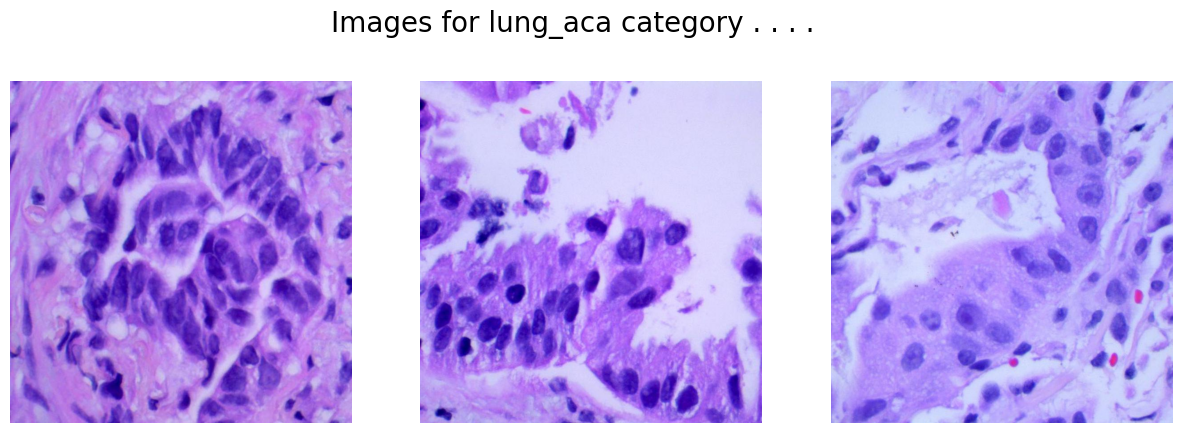

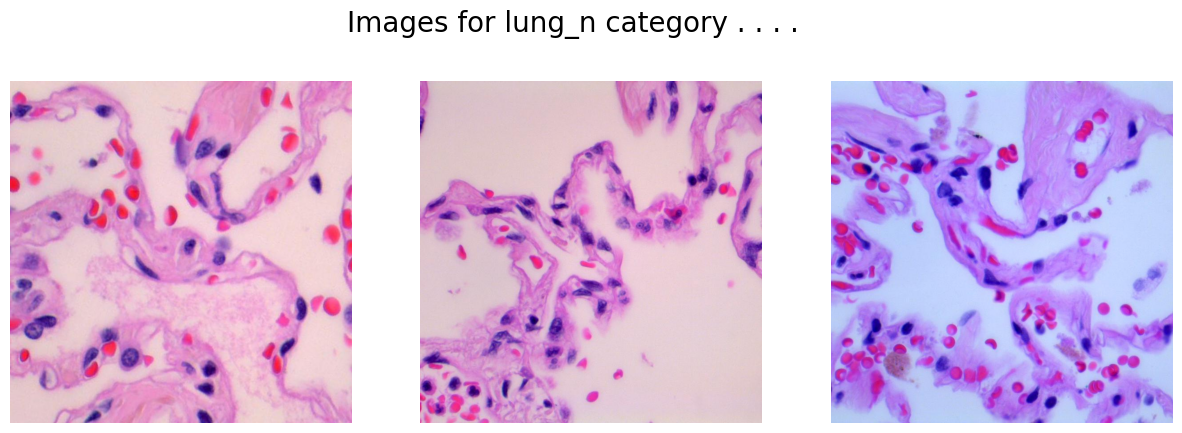

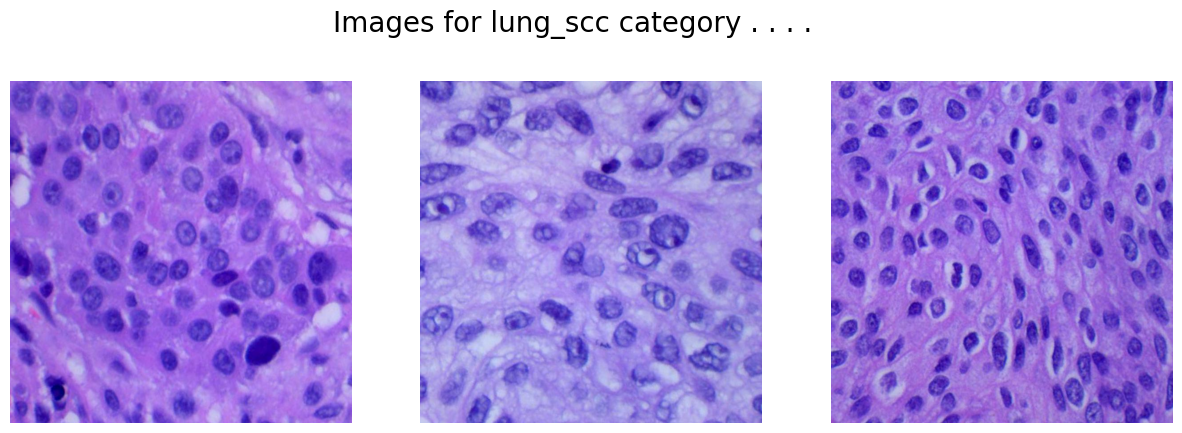

In [6]:
path =r"C:\Users\rahul\Downloads\archive"

for cat in classes:
	image_dir = f'{path}/{cat}'
	images = os.listdir(image_dir)

	fig, ax = plt.subplots(1, 3, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

	for i in range(3):
		k = np.random.randint(0, len(images))
		img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
		ax[i].imshow(img)
		ax[i].axis('off')
	plt.show()


In [7]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [8]:
X = []
Y = []

for i, cat in enumerate(classes):
	images = glob(f'{path}/{cat}/*.jpeg')

	for image in images:
		img = cv2.imread(image)
	
		X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
		Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
												test_size = SPLIT,
												random_state = 2022)
print(X_train.shape, X_val.shape)

(20000, 256, 256, 3) (5000, 256, 256, 3)


In [10]:
model = keras.models.Sequential([
	layers.Conv2D(filters=32,
				kernel_size=(5, 5),
				activation='relu',
				input_shape=(IMG_SIZE,
							IMG_SIZE,
							3),
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=64,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=128,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Flatten(),
	layers.Dense(256, activation='relu'),
	layers.BatchNormalization(),
	layers.Dense(128, activation='relu'),
	layers.Dropout(0.3),
	layers.BatchNormalization(),
	layers.Dense(5, activation='softmax')
])

In [11]:
keras.utils.plot_model(
	model,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics = ['accuracy']
)


In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.90:
			print('\n Validation accuracy has reached upto \
					90% so, stopping further training.')
			self.model.stop_training = True


es = EarlyStopping(patience=3,
				monitor='val_accuracy',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)


In [14]:
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])


Epoch 1/10
313/313 [==============================] - 1493s 5s/step - loss: 0.5007 - accuracy: 0.7883 - val_loss: 3.3019 - val_accuracy: 0.5680 - lr: 0.0010
Epoch 2/10
313/313 [==============================] - 1205s 4s/step - loss: 0.2580 - accuracy: 0.8990 - val_loss: 3.1303 - val_accuracy: 0.5650 - lr: 0.0010
Epoch 3/10
313/313 [==============================] - 3451s 11s/step - loss: 0.1992 - accuracy: 0.9238 - val_loss: 17.7003 - val_accuracy: 0.1998 - lr: 0.0010
Epoch 4/10
313/313 [==============================] - 1507s 5s/step - loss: 0.1541 - accuracy: 0.9431 - val_loss: 1.2294 - val_accuracy: 0.7680 - lr: 0.0010
Epoch 5/10
313/313 [==============================] - 1512s 5s/step - loss: 0.1321 - accuracy: 0.9512 - val_loss: 1.4534 - val_accuracy: 0.6980 - lr: 0.0010
Epoch 6/10
313/313 [==============================] - ETA: 0s - loss: 0.1042 - accuracy: 0.9613
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
313/313 [==============================] 

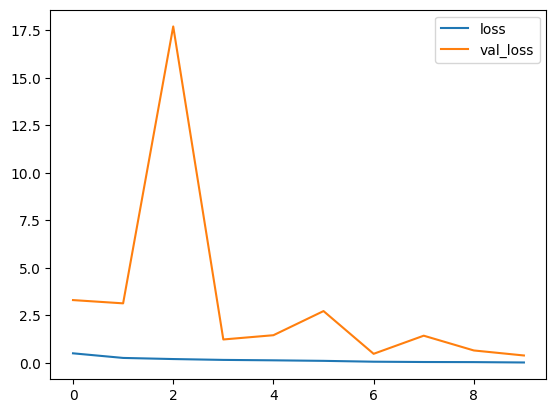

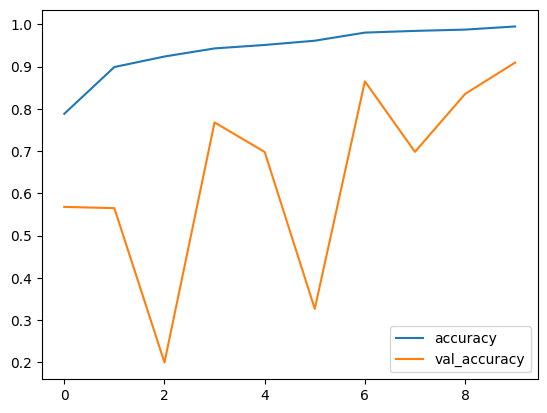

In [15]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [16]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

157/157 [==============================] - 68s 429ms/step


In [21]:
Y_pred

array([4, 4, 2, ..., 3, 3, 4], dtype=int64)

In [17]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[911,  29,   1,   4,  22],
       [ 36, 981,   0,   2,   0],
       [  0,   0, 684,   1, 325],
       [  0,   0,  23, 975,   1],
       [  0,   0,   8,   0, 997]], dtype=int64)

In [18]:
print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))


              precision    recall  f1-score   support

   colon_aca       0.96      0.94      0.95       967
     colon_n       0.97      0.96      0.97      1019
    lung_aca       0.96      0.68      0.79      1010
      lung_n       0.99      0.98      0.98       999
    lung_scc       0.74      0.99      0.85      1005

    accuracy                           0.91      5000
   macro avg       0.92      0.91      0.91      5000
weighted avg       0.92      0.91      0.91      5000



In [19]:
import pickle

In [20]:
with open("lung_cancer.pkl", "wb") as f:
    pickle.dump(model,f )

In [29]:
print(X)

[[[[236 234 255]
   [227 209 250]
   [231 183 241]
   ...
   [213 169 210]
   [208 158 200]
   [223 170 213]]

  [[245 231 255]
   [233 206 250]
   [235 183 243]
   ...
   [219 175 216]
   [226 172 215]
   [235 174 218]]

  [[247 222 250]
   [239 205 252]
   [229 174 237]
   ...
   [220 175 214]
   [235 177 218]
   [237 171 213]]

  ...

  [[244 208 250]
   [235 199 241]
   [243 206 246]
   ...
   [240 202 250]
   [234 196 244]
   [226 189 235]]

  [[250 210 252]
   [241 205 247]
   [242 210 251]
   ...
   [233 195 247]
   [242 205 255]
   [240 203 253]]

  [[254 210 251]
   [249 211 253]
   [248 216 255]
   ...
   [231 192 248]
   [235 196 251]
   [236 197 252]]]


 [[[226 164 200]
   [241 183 218]
   [239 185 220]
   ...
   [235 254 251]
   [233 253 248]
   [239 255 248]]

  [[243 186 224]
   [242 188 225]
   [240 189 226]
   ...
   [240 253 255]
   [237 251 250]
   [240 250 250]]

  [[250 199 236]
   [237 189 225]
   [235 187 223]
   ...
   [240 249 253]
   [238 243 252]
   [239 241